# Time-Series Forecasting using ARIMA
## Assessment of Forecast and price fluctuations in Amazon Stock
-----

## Import libraries

In [24]:
!pip install pmdarima

In [23]:
import warnings 
warnings.filterwarnings('ignore')

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from yahoo_fin.stock_info import get_data
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error, mean_absolute_error
register_matplotlib_converters()
sns.set_style("whitegrid")

## Get data

In [26]:
def read_data(tick_symbol, start_date, end_date):
    data = get_data(tick_symbol, start_date=start_date, end_date=end_date, index_as_date = False)
    return data

In [27]:
data = read_data('AMZN', '2017', '2021-08-23')

## View shape and format of data

In [28]:
data.shape

(1167, 8)

In [29]:
data_prices = data[['date','open','high','low','close']]
data_prices = data_prices.set_index(data_prices['date'])
data_prices = data_prices.drop(columns = ['date'])
data_prices

,open,high,low,close
date,,,,
2017-01-03,757.919983,758.760010,747.700012,753.669983
2017-01-04,758.390015,759.679993,754.200012,757.179993
2017-01-05,761.549988,782.400024,760.260010,780.450012
2017-01-06,782.359985,799.440002,778.479980,795.989990
2017-01-09,798.000000,801.770020,791.770020,796.919983
...,...,...,...,...
2021-08-16,3283.000000,3300.000000,3211.129883,3298.989990
2021-08-17,3277.500000,3280.489990,3225.679932,3241.959961
2021-08-18,3241.989990,3254.100098,3200.000000,3201.219971


## View prices and stationarity 

In [30]:
data_prices['SMA20'] = data_prices['close'].rolling(12).mean() 
data_prices['SMA20_std'] = data_prices['close'].rolling(12).std()

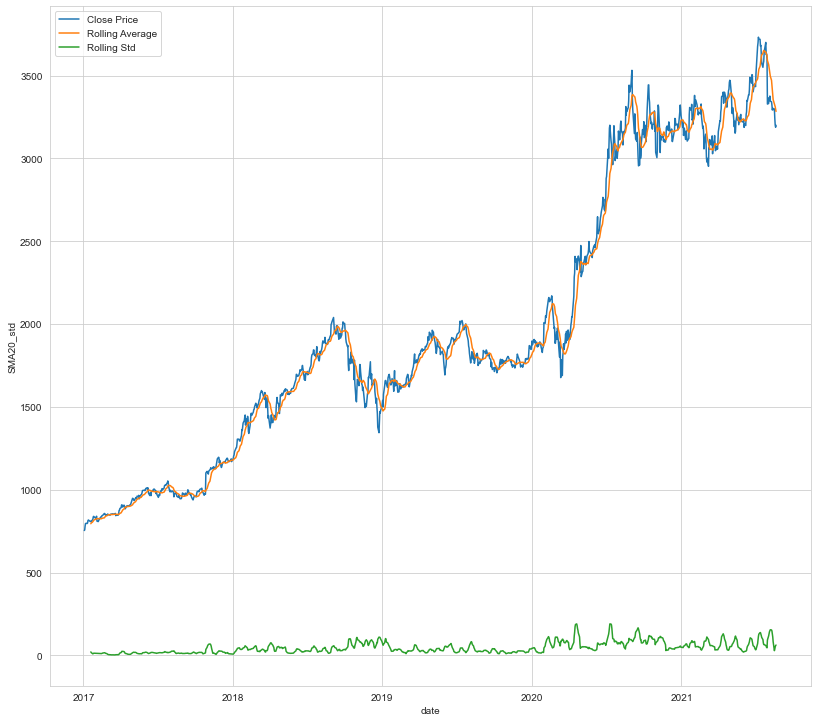

In [31]:
f = plt.figure(figsize=(30,12.5))
ax = f.add_subplot(121)
sns.lineplot(data = data_prices, x = data_prices.index, y = 'close', label = 'Close Price', ax =ax)
sns.lineplot(data = data_prices, x = data_prices.index, y = 'SMA20', label = 'Rolling Average', ax =ax)
sns.lineplot(data = data_prices, x = data_prices.index, y = 'SMA20_std', label = 'Rolling Std', ax =ax )


Data is not maintaining stationarity requirements, begin processing of moving average and standard deviation

## Ensure stationarity of time-series

No handles with labels found to put in legend.


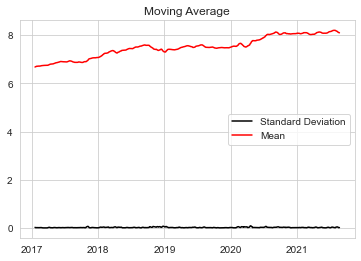

In [32]:
df_log = np.log(data_prices['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Stationarity has been enforced

## View sesonality of data

<Figure size 432x288 with 0 Axes>

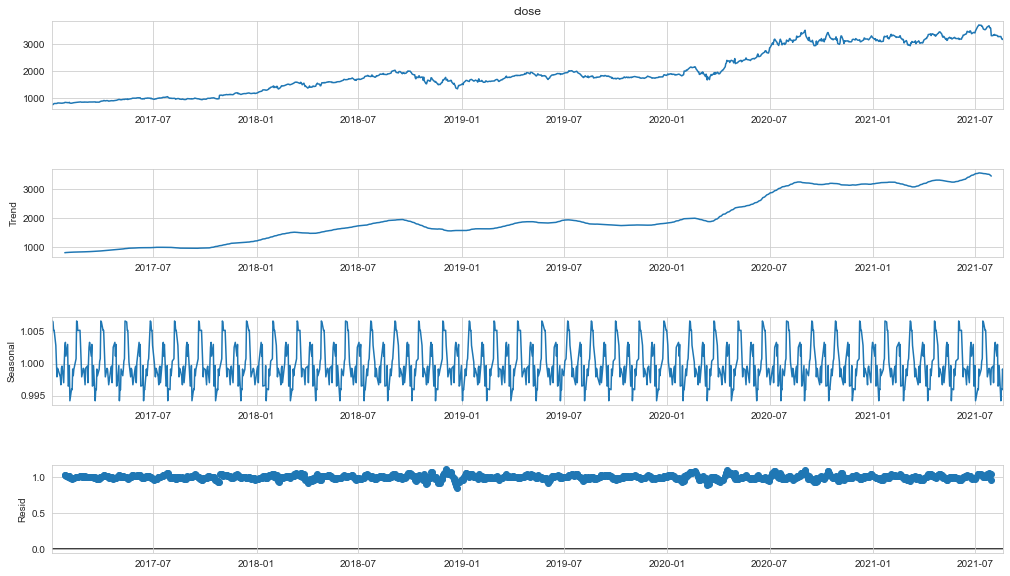

In [33]:
result = seasonal_decompose(data_prices['close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## View train and test data

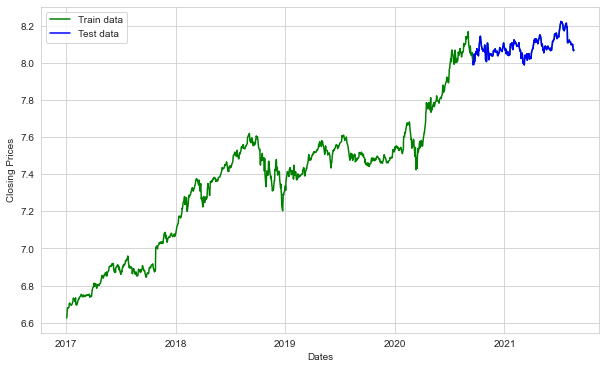

In [34]:
test_data, train_data = df_log[int(len(df_log)*0.8):], df_log[:int(len(df_log)*0.8)]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## Model the Forecast

In [35]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4738.647, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4740.639, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4740.564, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4734.781, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4738.693, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4738.729, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4736.686, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4735.985, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.211 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  933
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2373.319
Date:                Thu, 07 Oct 2021   AIC                          -4740.639
Time:                       

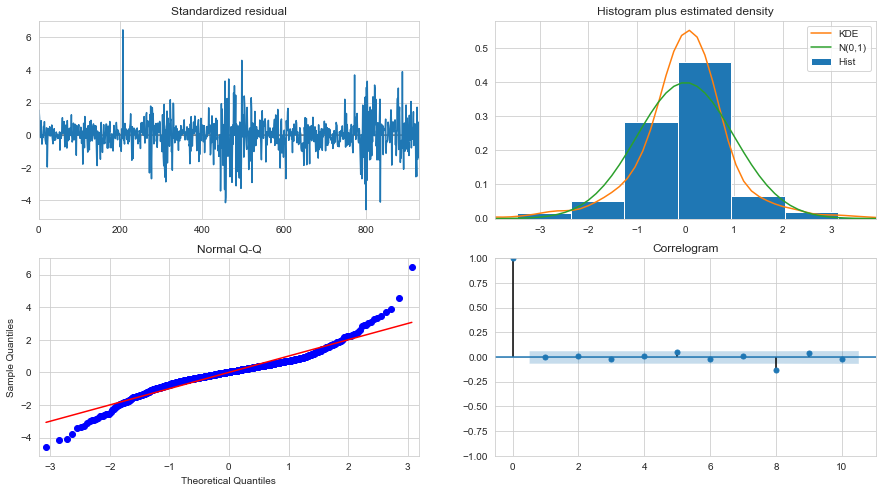

In [36]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

* Data is fairly normal with consistent deviations from the true mean
* Normality assumptions is somewhat satisfied, still some unexplained relationships
* Some estimates are fairly deviated from the predicted model, explained via Standardized residuals

## Train model

In [37]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  932
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2373.320
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 07 Oct 2021   AIC                          -4740.639
Time:                        14:30:48   BIC                          -4726.127
Sample:                             1   HQIC                         -4735.105
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      2.592      0.010       0.000       0.003
ar.L1.D.close    -0.0654      0.033     -2.000      0.045      -0.130      -0.001
                                    Root

## Scaled Values

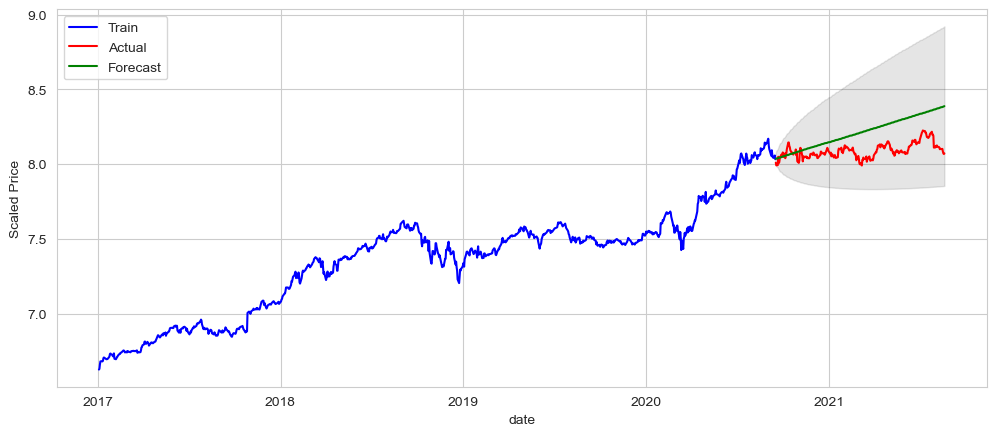

In [38]:
# Forecast
fc, se, conf = fitted.forecast(234, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)

sns.lineplot(x = train_data.index, y = train_data.values, color = 'blue', label = 'Train')
sns.lineplot(x = test_data.index, y = test_data.values, color = 'red', label = 'Actual')
sns.lineplot(x = fc_series.index, y = fc_series.values, color = 'green', label = 'Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.ylabel("Scaled Price")
plt.legend(loc='upper left')

## Unscaled and True values

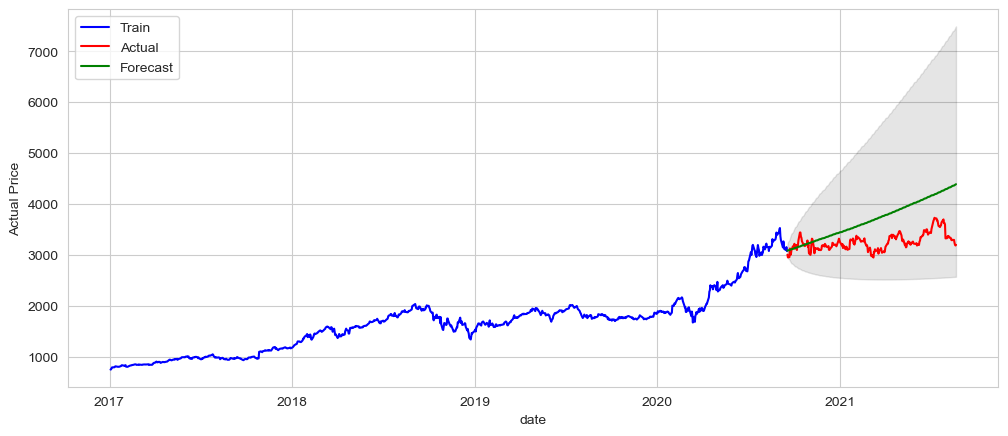

In [39]:
plt.figure(figsize=(12,5), dpi=100)
sns.lineplot(x = train_data.index, y = np.exp(train_data.values), color = 'blue', label = 'Train')
sns.lineplot(x = test_data.index, y = np.exp(test_data.values), color = 'red', label = 'Actual')
sns.lineplot(x = fc_series.index, y = np.exp(fc_series.values), color = 'green', label = 'Forecast')
plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
                 color='k', alpha=.10)
plt.ylabel("Actual Price")
plt.legend(loc='upper left')

## View predictions from forecasted values

In [42]:
#calculate difference in true vs predicted values
difference = np.exp(fc_series) - np.exp(test_data)

#view forcaste in table
view_forecasts = pd.DataFrame({'Actual Price':np.exp(test_data), 'Forecasted Price':np.exp(fc_series), 'Difference':difference})
view_forecasts

,Actual Price,Forecasted Price,Difference
date,,,
2020-09-17,3008.729980,3088.113118,79.383137
2020-09-18,2954.909912,3092.432494,137.522582
2020-09-21,2960.469971,3097.132678,136.662707
2020-09-22,3128.989990,3101.815452,-27.174538
2020-09-23,2999.860107,3106.506915,106.646808
...,...,...,...
2021-08-16,3298.989990,4364.679574,1065.689584
2021-08-17,3241.959961,4371.280967,1129.321006
2021-08-18,3201.219971,4377.892344,1176.672373


### We're 95% confident that the true price of Amazon's stock will fluctuate between the following 2.5th and 97.5th percentiles in the future

In [44]:
view_95 = pd.DataFrame({'2.5th Percentile': np.exp(lower_series), '97.5th Percentile': np.exp(upper_series)})
view_95

,2.5th Percentile,97.5th Percentile
date,,
2020-09-17,2975.461767,3205.029463
2020-09-18,2939.072797,3253.794443
2020-09-21,2911.874447,3294.177342
2020-09-22,2889.631853,3329.579541
2020-09-23,2870.599976,3361.800772
...,...,...
2021-08-16,2571.335191,7408.768741
2021-08-17,2572.268592,7428.500021
2021-08-18,2573.208718,7448.265367


## Calculate performance

In [41]:
import math
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 0.02203225766623146
MAE: 0.12703503845781564
RMSE: 0.14843267048137165
MAPE: 0.0156968659840305
